# Neural network which detect numbers from photo

## Imports:

In [699]:
import datetime

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
print('Versions: ', [v.__name__ + ': ' + v.__version__ for v in [np, matplotlib]])

Versions:  ['numpy: 1.23.1', 'matplotlib: 3.5.1']


## Research Data:

Target: 5


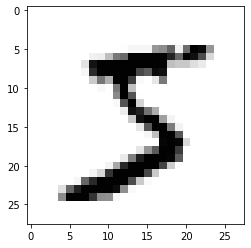

In [700]:
def collect_num_line(num: int, dataset: str) -> tuple:
    """Show line in file"""
    i = 0
    image_data = None
    with open(dataset, 'r') as file:
        for line in file:
            image_data = line.split(',')
            if i == num: break
            i += 1
        return int(image_data.pop(0)), np.asfarray(image_data).reshape(28, 28)

target, array = collect_num_line(0,'mnist_dataset/mnist_train_100.csv')
print(f'Target: {target}')
plt.imshow(array, cmap='Greys', interpolation=None)

In [701]:
# Data normalizing (switch from 0-255 to 0.01-1 selection)
def convert(image_data: np.array):
    scaled_input = (np.asfarray(image_data) / 255.0 * 0.99) + 0.01
    return scaled_input

## Data implementation structure:

In [702]:
class MnistNum:

    def __init__(self, filename: str, field=0) -> None:
        i = 0
        image_data = None
        with open(filename, 'r') as file:
            for line in file:
                image_data = line.split(',')
                if i == field: break
                i += 1

        # Ready values:
        self.marker = int(image_data.pop(0))
        self.image = np.asfarray(image_data).reshape(28, 28)
        self.input_image = ((np.asfarray(image_data) / 255.0) * 0.99) + 0.01
        self.targets = np.zeros(10) + 0.01
        self.targets[self.marker] = 0.99
        
        # Network representation
        self.neural_answer = None
        self.neural_outputs = None
    
    
    def show(self) -> None:
        print(f'Target: {self.marker}')
        print(f'Answer: {self.neural_answer}')
        print(f'Neural outputs: \n{self.neural_outputs.T}')
        plt.imshow(self.image, cmap='Greys', interpolation=None)
        plt.show()


    def __repr__(self) -> str:
        pass
    
    
    def __str__(self) -> str:
        return f'Num: {self.marker}, Answer: {self.neural_answer}'

#print('Normalized data: ', MnistNum('mnist_dataset/mnist_test_10.csv').input_image)

## Used formulas:
#### Activation function:
$$f(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^-x }$$
#### Reverse error distribution with gradient:
$$-(e_o) \times  \sigma( \Sigma_i w_{io} o_i) \times (1 - \sigma(\Sigma_i w_{io} o_i) \times o_i$$

## Neural Network:

In [703]:
class NeuralNetwork:

    
    @staticmethod
    def activation_func(num: float) -> float:
        # Sigmoid:
        return 1 / (1 + np.exp(-num))


    @staticmethod
    def check_accuracy(network: object, ready_dataset: list) -> float:
        correct = 0.0
        for image in ready_dataset:
            if image.marker == image.neural_answer:
                correct += 1.0
        network.accuracy = correct/len(ready_dataset)
        return network.accuracy
    

    def __init__(self, inputs: int, hidden1: int, hidden2: int, output: int, learningspeed = 0.3) -> None:
        self.innodes = inputs
        self.hnnodes1 = hidden1
        self.hnnodes2 = hidden2
        self.ounodes = output
        self.lr = learningspeed

        # Initialize weights between nodes:
        self.weights_in_hn1 = np.random.normal(0.0, (self.hnnodes1 ** -0.5),
                                              (self.hnnodes1, self.innodes))
        self.weights_hn1_hn2 = np.random.normal(0.0, (self.hnnodes2 ** -0.5),
                                               (self.hnnodes2, self.hnnodes1))
        self.weights_hn2_ou = np.random.normal(0.0, (self.ounodes ** -0.5),
                                              (self.ounodes, self.hnnodes2))

        self.trained = False
        self.trained_time = None
        self.accuracy = None


    def __del__(self):
        print('Bye Bye my little skynet ;(')
    
    
    def __str__(self):
        return f'Neural Network Object, with learning speed: {self.lr} and trained status: {self.trained}, Accuracy: {str(self.accuracy)[0:4:]}'
    
    
    def __repr__(self):
        return f'Object={type(self)}, \
                 \nTrainedStatus={self.trained}, \
                 \nSpeed={self.lr}, \
                 \nAccuracy={self.accuracy}, \
                 \nTimeTrained={self.trained_time}, \
                 \nLayers=in{self.innodes}:hn{self.hnnodes1}:hn{self.hnnodes2}:ou{self.ounodes}'

 
    def train(self, datapath: str, repeats: int) -> None:
        start_time = datetime.datetime.now()
        
        for i in range(repeats):
            image_data = MnistNum(datapath, i)
            inputs = np.array(image_data.input_image, ndmin=2).T
            targets = np.array(image_data.targets, ndmin=2).T

            hidden_inputs1 = np.dot(self.weights_in_hn1, inputs)
            hidden_outputs1 = self.activation_func(hidden_inputs1)

            hidden_inputs2 =  np.dot(self.weights_hn1_hn2, hidden_outputs1)
            hidden_outputs2 = self.activation_func(hidden_inputs2)

            final_inputs = np.dot(self.weights_hn2_ou, hidden_outputs2)
            final_outputs = self.activation_func(final_inputs)

            output_errors = targets - final_outputs
            hidden_errors2 = np.dot(self.weights_hn2_ou.T, output_errors)
            hidden_errors1 = np.dot(self.weights_hn1_hn2.T, hidden_errors2)

            # Reverse error distribution formula for network weights:
            self.weights_in_hn1 += self.lr * np.dot(
                (hidden_errors1 * hidden_outputs1 * (1.0 - hidden_outputs1)),
                np.transpose(inputs))
            self.weights_hn1_hn2 += self.lr * np.dot(
                (hidden_errors2 * hidden_outputs2 * (1.0 - hidden_outputs2)),
                np.transpose(hidden_outputs1))
            self.weights_hn2_ou += self.lr * np.dot(
                (output_errors * final_outputs * (1.0 - final_outputs)),
                np.transpose(hidden_outputs2))
            
        self.trained = True
        self.trained_time = str(datetime.datetime.now() - start_time).split(".")[0]

 
    def query(self, datapath: str, repeats: int, list_images: list) -> None:
        
        # Multiply matrix's, sum and activate:
        for i in range(repeats):
            image_data = MnistNum(datapath, i)

            list_images.append(image_data)

            inputs = np.array(image_data.input_image, ndmin=2).T

            hidden_inputs1 = np.dot(self.weights_in_hn1, inputs)
            hidden_outputs1 = self.activation_func(hidden_inputs1)

            hidden_inputs2 = np.dot(self.weights_hn1_hn2, hidden_outputs1)
            hidden_outputs2 = self.activation_func(hidden_inputs2)

            final_inputs = np.dot(self.weights_hn2_ou, hidden_outputs2)
            final_outputs = self.activation_func(final_inputs)
        
            image_data.neural_outputs = final_outputs
            image_data.neural_answer = np.unravel_index(final_outputs.argmax(), final_outputs.shape)[0]

In [704]:
IMAGES = list()
test = NeuralNetwork(784, 64, 32, 10, 0.2)
test.train(datapath='mnist_dataset/mnist_train.csv', repeats=7500)
test.query(datapath='mnist_dataset/mnist_test_10.csv', repeats=10, list_images=IMAGES)
# Answer show array with a preferred chance [0,1,2,3,4,5,6,7,8,9]

Bye Bye my little skynet ;(


## Answers:

Target: 7
Answer: 7
Neural outputs: 
[[0.0191761  0.00957258 0.0141965  0.00751164 0.00458367 0.00397813
  0.00116507 0.96335221 0.00231921 0.04616152]]


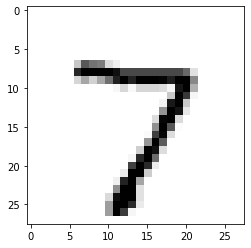

Target: 2
Answer: 2
Neural outputs: 
[[0.04811781 0.00463205 0.37798816 0.05876327 0.0041582  0.15214256
  0.329505   0.00053932 0.002988   0.00154342]]


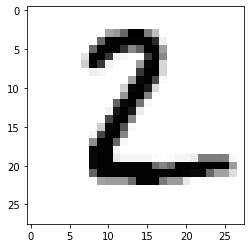

Target: 1
Answer: 1
Neural outputs: 
[[0.00096931 0.95426072 0.06452315 0.01334059 0.00212728 0.02074668
  0.0071742  0.00607513 0.03869962 0.00601842]]


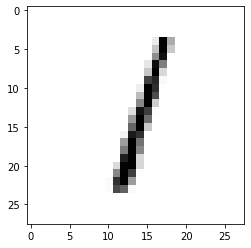

Target: 0
Answer: 0
Neural outputs: 
[[0.96913263 0.00104924 0.0167731  0.01111368 0.00053847 0.03195558
  0.02355451 0.03789309 0.00935205 0.008004  ]]


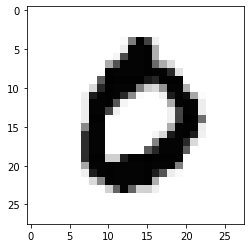

Target: 4
Answer: 4
Neural outputs: 
[[0.00845268 0.00036153 0.16117021 0.0069386  0.58696287 0.00841723
  0.00656859 0.04123727 0.02232496 0.08862071]]


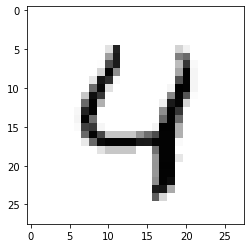

Target: 1
Answer: 1
Neural outputs: 
[[0.00099927 0.94346016 0.06594095 0.020331   0.00107064 0.02232005
  0.00495238 0.00605445 0.05766106 0.00740332]]


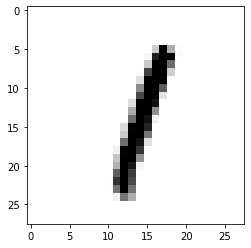

Target: 4
Answer: 4
Neural outputs: 
[[0.00583207 0.00293467 0.00259295 0.0132635  0.76820825 0.23903814
  0.00812404 0.0082561  0.03273216 0.10145253]]


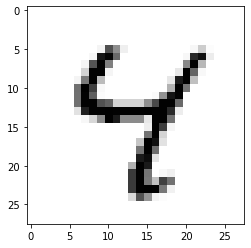

Target: 9
Answer: 5
Neural outputs: 
[[0.00625228 0.00628368 0.00113973 0.03078977 0.22788906 0.57360033
  0.01480616 0.00620539 0.02878318 0.13916658]]


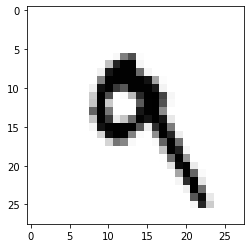

Target: 5
Answer: 5
Neural outputs: 
[[0.22810479 0.00512772 0.00209814 0.03785272 0.00048816 0.4029619
  0.0180564  0.12655015 0.00160582 0.00383177]]


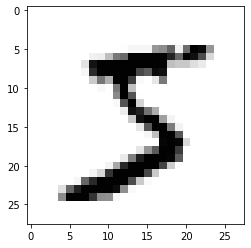

Target: 9
Answer: 7
Neural outputs: 
[[0.02383248 0.00241981 0.00277664 0.00628552 0.08003523 0.00826889
  0.00205763 0.44424354 0.00232817 0.3183973 ]]


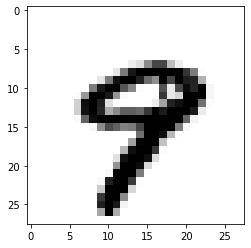

In [705]:
for data in IMAGES:
    data.show()

## Accuracy:

In [706]:
print(f'Accuracy: {NeuralNetwork.check_accuracy(test, IMAGES)}')

Accuracy: 0.8


## Neural Network metadata

In [707]:
print(test)

Neural Network Object, with learning speed: 0.2 and trained status: True, Accuracy: 0.8


In [708]:
print(repr(test))

Object=<class '__main__.NeuralNetwork'>,                  
TrainedStatus=True,                  
Speed=0.2,                  
Accuracy=0.8,                  
TimeTrained=0:10:29,                  
Layers=in784:hn64:hn32:ou10
